# Case Study: Sentiment Analysis

### Setup

Import modules, read data

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

sns.set()

# Read in the data
df = pd.read_csv('./data/reviews.csv')
# Sample the data to speed up computation
# Comment out this line to match with lecture

df["Reviews"].head(20)


0     Very good one! Better than Samsung S and iphon...
1     The phone needed a SIM card, would have been n...
2     I was 3 months away from my upgrade and my Str...
3                        an experience i want to forget
4           GREAT PHONE WORK ACCORDING MY EXPECTATIONS.
5     I fell in love with this phone because it did ...
6     I am pleased with this Blackberry phone! The p...
7     Great product, best value for money smartphone...
8                 except samsung pay everything is good
9             I've bought 3 no problems. Fast delivery.
10                         Great phone for the price...
11    My mom is not good with new technoloy but this...
12    The charger didnt work, I suppose that it mean...
13    I loved it and thanks so much because you made...
14    Amazing phone especially for the price. I love...
15        thanks... excellent...love my iphone 4s used.
16    I purchase it for my friend, she like it alot ...
17    I generally dont write reviews but this ph

In [55]:
# Remove missing values
df.dropna(inplace=True)

# Drop reviews with neutral ratings
df = df[df['Rating'] != 3]

"Super! No problem with the phone"
"Many problems with the phone"

# Map ratings 4 and 5 to "positive" 
# Map ratings 1 and 2 to "negative"
df['Positively Rated'] = np.where(df['Rating'] > 3, 1, 0)
df.Reviews.head(50)

1     The phone needed a SIM card, would have been n...
2     I was 3 months away from my upgrade and my Str...
3                        an experience i want to forget
4           GREAT PHONE WORK ACCORDING MY EXPECTATIONS.
5     I fell in love with this phone because it did ...
6     I am pleased with this Blackberry phone! The p...
7     Great product, best value for money smartphone...
9             I've bought 3 no problems. Fast delivery.
10                         Great phone for the price...
11    My mom is not good with new technoloy but this...
12    The charger didnt work, I suppose that it mean...
13    I loved it and thanks so much because you made...
14    Amazing phone especially for the price. I love...
16    I purchase it for my friend, she like it alot ...
17    I generally dont write reviews but this phone ...
18    I bought this phone for my mom and sent it to ...
19                                         got me going
20    Happy to be back! I broke my Lumia 1520.3 

In [29]:
# Most ratings are positive
df['Positively Rated'].mean()

0.7475328055525431

In [30]:

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], 
                                                    df['Positively Rated'], 
                                                    random_state=0)

In [31]:
print('X_train first entry:\n\n', X_train.iloc[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry:

 my daughter loves this phone,thanks


X_train shape:  (27663,)


# CountVectorizer

In [32]:

# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

In [33]:
feature_names = vect.get_feature_names_out()
feature_names[::1000]
# vect.get_feature_names()[::2000]

array(['00', '8hrs', 'anti', 'biometric', 'chao', 'costco', 'dinamico',
       'envió', 'flicking', 'guadalajara', 'increment', 'launch', 'mgpx',
       'object', 'phonen', 'purposes', 'responded', 'sharing', 'steffy',
       'thinn', 'updating', 'work4'], dtype=object)

Number of features generated

In [34]:
len(vect.get_feature_names_out())

21344

In [35]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<27663x21344 sparse matrix of type '<class 'numpy.int64'>'
	with 733003 stored elements in Compressed Sparse Row format>

In [36]:
# Train the model
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=500)

Compute the ROC curve and plot it. Compute the area under the ROC curve.

AUC:  0.895430723112348


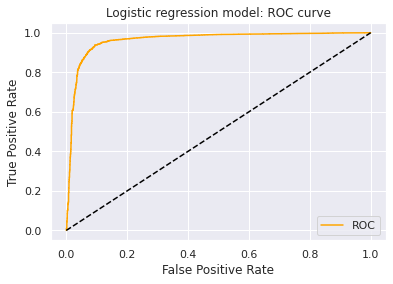

In [51]:
# Predict the transformed test documents
predictions = logreg.predict(vect.transform(X_test))
logreg_probs = logreg.predict_proba(vect.transform(X_test))
logreg_positive_probs = [p[1] for p in logreg_probs]

fpr, tpr, thresholds = roc_curve(y_test, logreg_positive_probs)

## Predicted probabilities from the logistic regression model
print('AUC: ', roc_auc_score(y_test, predictions))

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Logistic regression model: ROC curve')
    plt.legend()
    plt.show()
    
plot_roc(fpr, tpr)

In [38]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names_out())

# Sort the coefficients from the model
sorted_coef_index = logreg.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['worst' 'terrible' 'waste' 'junk' 'sucks' 'horrible' 'broken' 'slow'
 'useless' 'poor']

Largest Coefs: 
['excelent' 'excelente' 'excellent' 'love' 'perfect' 'loves' 'perfectly'
 'great' 'amazing' 'wonderful']


# TF-IDF

Fit another logistic regression model. This time vectorize using the DF-IDF vectorization.

In [44]:
import nltk
stopwords_en = nltk.corpus.stopwords.words("english")

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
idf_vect = TfidfVectorizer(
    lowercase=True,
    stop_words=stopwords_en,
    min_df=5
).fit(X_train)
len(idf_vect.get_feature_names_out())

5820

In [52]:
X_train_vectorized_idf = idf_vect.transform(X_train)

model = LogisticRegression(max_iter=500)
model.fit(X_train_vectorized_idf, y_train)

predictions_idf = model.predict(idf_vect.transform(X_test))

roc_score = roc_auc_score(y_test, predictions_idf)
roc_score

print('AUC: ', roc_auc_score(y_test, predictions))

#roc_curve()

AUC:  0.895430723112348


In [53]:
feature_names = np.array(vect.get_feature_names_out())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['judicious' 'outsources' 'outsourced' 'outsource' 'outsmarts' 'outshines'
 'outshine' 'outstand' 'outset' 'outright']

Largest tfidf: 
['the' 'and' 'this' 'to' 'it' 'is' 'phone' 'you' 'iphone' 'for']


In [48]:
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['clunker' 'descrito' 'dejo' 'connecting' 'credits' 'affected' 'descent'
 'aweek' 'cargador' 'bro']

Largest Coefs: 
['atd' 'blackberrry' 'amplet' 'camer' '45min' 'anomaly' 'blackberryworld'
 '24' 'assets' 'amper']


In [17]:
# These reviews are treated the same by our current model
print(model.predict(idf_vect.transform(['not an issue, phone is working',
                                    'an issue, phone is not working'])))

[0 0]


# N-grams

Fit a third logistic regression model using the TF-IDF vectorization. This time include
bi-grams as features and exclude features with document frequency less than 5.

In [18]:
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names())

33529

In [19]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

/home/amarov/proj/taw2019/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC:  0.9167459691585975


In [20]:
feature_names = np.array(vect.get_feature_names())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['junk' 'worst' 'no good' 'not good' 'poor' 'broken' 'terrible' 'sucks'
 'horrible' 'slow']

Largest Coefs: 
['excellent' 'excelente' 'excelent' 'perfect' 'great' 'not bad' 'love'
 'no problems' 'awesome' 'amazing']


In [21]:
# These reviews are now correctly identified
print(model.predict(vect.transform(['not an issue, phone is working',
                                    'an issue, phone is not working'])))

[0 0]
